# Implementación del algoritmo Apriori

##### Por: Daniela Flores Villanueva

En este *notebook* se define lo necesario para implementar el algoritmo Apriori con la menor dependencia de código externo posible. Posteriormente, se emplea la implementación propuesta para minar reglas de asociación que presenten altos valores para ciertas métricas y se analizan separadamente. Finalmente, se entrega una forma de visualizar un conjunto de reglas de asociación.

## Librerías utilizadas

- `numpy`: se utilizó para cargar los datos del Spotify RecSys Challenge, que venían en una arreglo serializado de `numpy`.
- `collections`: se usó su clase `defaultdict`, para formar los diccionarios con los contadores de soporte de cada *itemset*.
- `pandas`: para obtener el contador de soporte de las canciones.
- `altair`: para realizar visualizaciones.

In [1]:
import numpy as np
import collections
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Para generar todas las combinaciones largo $r$ que pueden extraerse de un iterable, se define la siguiente función. Esta implementación fue extraída de [este](https://docs.python.org/3/library/itertools.html#itertools.combinations) recurso. 

In [2]:
def combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i + 1, r):
            indices[j] = indices[j - 1] + 1
        yield tuple(pool[i] for i in indices)

## Clase Apriori

La implementación presentada en este *notebook* se basa en la creación de un objeto de clase `Apriori` que, en primer lugar, recibe los siguientes parámetros:

- `data`: corresponde a las transacciones, en forma de `numpy.array`.
- `min_support`: soporte mínimo para que un `itemset` sea considerado frecuente.
- `min_confidence`: confianza mínima para que cierta regla de asociación sea retornada.
- `min_lift`: *lift* mínimo para que cierta regla de asociación sea retornada.

### Métodos

- `prepare_data`: convierte los datos recibidos (`self.data`) en una lista de conjuntos, donde cada conjunto corresponde a una lista de reproducción. De esta forma, se evitan canciones repetidas en las listas. También, se guarda en `self.songs_counter` un contador con la frecuencia de cada canción. Esta información permitirá formar el conjunto L_1.
- `get_songs_appearances`: gracias a este método, se guarda un diccionario cuyas llaves son nombres de canciones y los valores el conjunto de índices de las listas de reproducción donde aparece dicha canción. Esto permitirá obtener el contador de soporte de un *itemset* con facilidad.
- `generate_L_1`: con esto se obtienen los *itemsets* frecuentes de largo 1, es decir, las canciones que aparecen un porcentaje de veces mayor al mínimo soporte definido.
- `has_unfrequent_subset`: este método permite verificar la propiedad de monotonicidad de un *k-itemset*: si el itemset es frecuente, entonces todos sus subconjuntos deben serlo también. Este método finalmente no se ocupó, pues demoraba la ejecución del método `fit`. Cabe destacar, eso sí, que la poda (realizada en `prune_itemsets`) es lo suficientemente veloz como para prescindir de este paso al menos en esta implementación. Lo correcto hubiese sido, por supuesto, incluir este paso de verificación al generar candidatos a *itemsets* frecuentes.
- `generate_new_candidates`: este método permite generar un nuevo conjunto de posibles *itemsets* frecuentes. Esto se hace a partir de la unión de un conjunto de *itemsets* frecuentes consigo mismo. Un *itemset* se "fusiona" con otro solo si sus primeros $k - 2$ elementos son iguales. Puede observarse que se dejó comentada la verificación de la propiedad de monotonocidad (`if not self.has_unfrequent_subset(c, current_itemsets, k)`), puesto que su utilización, aunque correcta, agrega alrededor de 8 segundos extra al tiempo de ejecución del método `fit`.
- `calculate_subset_count`: calcula el contador de soporte de un *itemset*. Gracias al diccionario generado con `get_songs_appearances`, es fácil obtener el contador de soporte de un *itemset*: basta con obtener las listas de reproducción en que aparece cada canción del *itemset* y luego intersectar esos conjuntos de *playlists*. El largo de la intersección corresponderá al contador de soporte de *itemset*.
- `prune_itemsets`: retorna el conjunto de *itemsets* que superan el mínimo soporte definido.
- `export_frequent_itemsets_to_csv`: permite exportar los *itemsets* frecuentes junto a su contador de soporte y a su soporte a un archivo `csv`.
- `fit`: método que genera los *itemsets* frecuentes.
- `get_association_rule_from_itemset`: Dado un *itemset* $I$ se forman todas las combinaciones posibles de $X \rightarrow Y$, donde $X \subset I$ y $Y = I - X$. Es importante notar que solo se consideran reglas de asociación aquellas en que tanto X como Y tengan largo mayor o igual a 1.
- `generate`: se generan todas las reglas de asociación posibles a partir de los *itemsets* frecuentes encontrados. Por defecto, se retornan ordenadas por *confidence*. El usuario puede cambiar esto mediante la modificación del parámetro `order_by`.
- `export_rules_to_csv`: se exportan las reglas a `csv`, gracias a un `DataFrame` de `pandas`.
- `get_n_top_rules`: permite obtener las $n$ reglas con mayor valor de la métrica determinada por el usuario (*confidence*, por defecto). Esta métrica puede corresponder a *confidence* o a *lift*. El criterio de ordenación se cambia a través de la modificación del parámetro `order_by`.
- `filter_rules`: método que permite filtrar las reglas según los umbrales de *confidence* y *lift* definidos al inicializar el objeto. Se puede filtrar por *confidence* y *lift* tanto de forma separada como integrada.

In [3]:
class Apriori:
    def __init__(self, data, min_support=0.01, min_confidence=0.01,
                 min_lift=1):
        self.data = data
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.min_lift = min_lift

    def prepare_data(self):
        self.playlists = list(self.data.item().values())
        self.playlists = [set(playlist) for playlist in self.playlists]
        unique_songs = [item for sublist in self.playlists for item in sublist]
        self.songs_counter = pd.Series(
            data=unique_songs).value_counts().to_dict()

    def get_songs_appearances(self):
        songs_in_playlists = collections.defaultdict(set)
        for index, playlist in enumerate(self.playlists):
            for song in playlist:
                songs_in_playlists[song].add(index)
        self.songs_in_playlists = songs_in_playlists

    def generate_L_1(self):
        self.L_1_counter = {
            song: times
            for song, times in self.songs_counter.items()
            if times / len(self.playlists) >= self.min_support
        }
        self.L_1 = [{song} for song in self.L_1_counter.keys()]

    def has_unfrequent_subset(self, candidate, current_itemsets, k):
        subsets = combinations(candidate, k - 1)
        for subset in subsets:
            if frozenset(subset) not in current_itemsets:
                return True
        return False

    def generate_new_candidates(self, current_itemsets, k):
        C_k = set()
        m = k - 2
        for candidate in current_itemsets:
            candidate = list(candidate)
            for aux_candidate in current_itemsets:
                aux_candidate = list(aux_candidate)
                can_join = True
                for i in range(k - 2):
                    if candidate[i] != aux_candidate[i]:
                        can_join = False
                        break
                if not can_join:
                    continue
                if candidate[k - 2] < aux_candidate[k - 2]:
                    c = candidate + [aux_candidate[k - 2]]
                    c = frozenset(sorted(c))
                    #                     if not self.has_unfrequent_subset(c, current_itemsets, k):
                    #                         C_k.add(c)
                    C_k.add(c)
        return C_k

    def calculate_subset_count(self, subset):
        playlists_inter = []
        for song in subset:
            playlists_inter.append(self.songs_in_playlists[song])
        return len(set.intersection(*playlists_inter))

    def prune_itemsets(self, C_k):
        C_k_counter = {}
        playlist_length = len(self.playlists)
        for candidate in C_k:
            C_k_counter[candidate] = self.calculate_subset_count(candidate)
        L_k_counter = {
            subset: times
            for subset, times in C_k_counter.items()
            if times / playlist_length >= self.min_support
        }
        return L_k_counter

    def export_frequent_itemsets_to_csv(self):
        self.frequent_itemsets_df = pd.DataFrame([
            item for sublist in self.k_frequent_itemsets.values()
            for item in sublist
        ]).round(3)
        self.frequent_itemsets_df.columns = ["itemset", "count_support"]
        self.frequent_itemsets_df["support"] = self.frequent_itemsets_df[
            "count_support"] / len(self.playlists)
        print("Generating file with frequent itemsets.")
        self.frequent_itemsets_df.to_csv(
            "frequent_itemsets.csv", index="False")
        return self.frequent_itemsets_df

    def fit(self):
        self.prepare_data()
        self.get_songs_appearances()
        self.generate_L_1()
        self.k_frequent_itemsets = {}
        self.k_frequent_itemsets[1] = sorted(
            self.L_1_counter.items(), key=lambda x: x[1], reverse=True)
        self.frequent_itemsets_length_gt2 = []
        k = 2
        current = self.L_1
        while len(current) != 0:
            C_k = self.generate_new_candidates(current, k)
            L_k_counter = self.prune_itemsets(C_k)
            L_k = L_k_counter.keys()
            self.frequent_itemsets_length_gt2.extend(L_k)
            self.k_frequent_itemsets[k] = sorted(
                L_k_counter.items(), key=lambda x: x[1], reverse=True)
            k += 1
            current = L_k
        self.export_frequent_itemsets_to_csv()

    def get_association_rule_from_itemset(self, itemset):
        itemset_count = self.calculate_subset_count(itemset)
        itemset_support = itemset_count / len(self.playlists)
        for i in range(1, len(itemset) + 1):
            for x_set in combinations(itemset, i):
                x_set = set(x_set)
                y_set = set(itemset) - x_set
                x_support = self.calculate_subset_count(x_set) / len(
                    self.playlists)
                x_y_support = self.calculate_subset_count(
                    x_set.union(y_set)) / len(self.playlists)
                rule_confidence = x_y_support / x_support
                if len(x_set) > 0 and len(y_set) > 0:
                    y_support = self.calculate_subset_count(y_set) / len(
                        self.playlists)
                    rule_lift = x_y_support / (x_support * y_support)
                    self.rules.append((x_set, y_set, rule_confidence,
                                       rule_lift))

    def generate(self):
        self.rules = []
        for itemset in self.frequent_itemsets_length_gt2:
            self.get_association_rule_from_itemset(itemset)
        self.export_rules_to_csv()

    def export_rules_to_csv(self):
        self.rules_df = pd.DataFrame(
            data=self.rules,
            columns=["antecedent", "consequent", "confidence",
                     "lift"]).round(3)
        print("Generating file with association rules.")
        self.rules_df["antecedent"] = list(
            map(tuple, self.rules_df["antecedent"]))
        self.rules_df["consequent"] = list(
            map(tuple, self.rules_df["consequent"]))
        self.rules_df.to_csv("association_rules.csv", index=False)

        return self.rules_df

    def get_n_top_rules(self, n, order_by="confidence"):
        sorted_df = self.rules_df.sort_values(
            order_by, ascending=False).head(n)
        print("Generating file with top {} rules sorted by {}.".format(
            n, order_by))
        sorted_df.to_csv(
            "top_{}_rule_by_{}.csv".format(n, order_by), index=False)
        return sorted_df

    def filter_rules(self, filter_by="both"):
        if filter_by == "both":
            filtered_rules = self.rules_df[
                (self.rules_df["confidence"] >= self.min_confidence)
                & (self.rules_df["lift"] >= self.min_lift)]
        elif filter_by == "confidence":
            filtered_rules = self.rules_df[self.rules_df["confidence"] >= self.
                                           min_confidence].sort_values(
                                               filter_by, ascending=False)
        else:
            filtered_rules = self.rules_df[
                self.rules_df["lift"] >= self.min_lift].sort_values(
                    filter_by, ascending=False)
        print(
            "Generating file with filtered rules. These are the first 10 rules."
        )
        display(filtered_rules.head(10))
        filtered_rules.to_csv("filtered_rules.csv", index=False)

## Prueba de la implementación sobre la base de datos entregada

En primer lugar, se cargan los datos.

In [4]:
spotify_data = np.load("spotify.npy")

Para definir un mínimo soporte adecuado, conviene estudiar la frecuencia de aparición de las distintas canciones del *data set*.

In [5]:
playlists = spotify_data.item().values()
unique_songs = [item for sublist in playlists for item in sublist]
pd.Series(unique_songs).value_counts().sort_values(ascending=False)[0:10]

Closer                         761
Home                           489
HUMBLE.                        470
Roses                          436
One Dance                      433
Ride                           429
Congratulations                410
Let Me Love You                403
Broccoli (feat. Lil Yachty)    402
Caroline                       395
dtype: int64

Es posible notar que la canción que más veces aparece, lo hace tan solo 761, lo que equivale al 7%. Por esta razón, el mínimo soporte empleado será 0.01. Así, se define un objeto de clase `Apriori`, al que se le entregan los datos (guardados en la variable `spotify_data`), el soporte mínimo deseado, la confianza mínima deseada y el mínimo lift requerido.

In [6]:
apriori = Apriori(
    data=spotify_data, min_support=0.01, min_confidence=0.5, min_lift=0.9)

Con el método *fit*, se generan los *itemsets* frecuentes, que permitirán obtener las reglas de asociación. Los *itemsets* se guardan en un archivo `.csv`.

In [7]:
apriori.fit()

Generating file with frequent itemsets.


Con los *itemsets* frecuentes ya encontrados, se procede a generar las reglas de asociación. Para no llenar el *notebook* con estas reglas (son 448), se guardan en un archivo `.csv`.

In [8]:
apriori.generate()

Generating file with association rules.


A continuación, se puede obtener las reglas ordenadas según un criterio definido por el usuario. En la siguiente celda, por ejemplo, se seleccionan las 10 reglas con mayor *confidence*

In [9]:
apriori.get_n_top_rules(10, "confidence")

Generating file with top 10 rules sorted by confidence.


,antecedent,consequent,confidence,lift
439,"(Mask Off, DNA.)","(HUMBLE.,)",0.909,19.550
398,"(DNA., XO TOUR Llif3)","(HUMBLE.,)",0.864,18.589
314,"(DNA.,)","(HUMBLE.,)",0.823,17.688
337,"(Mask Off, XO TOUR Llif3)","(HUMBLE.,)",0.804,17.283
350,"(Bounce Back, Broccoli (feat. Lil Yachty))","(Bad and Boujee (feat. Lil Uzi Vert),)",0.775,22.469
368,"(XO TOUR Llif3, Slippery (feat. Gucci Mane))","(HUMBLE.,)",0.765,16.455
373,"(Tunnel Vision, XO TOUR Llif3)","(HUMBLE.,)",0.750,16.129
433,"(Congratulations, Mask Off)","(HUMBLE.,)",0.747,16.063
403,"(Bounce Back, Mask Off)","(HUMBLE.,)",0.743,15.971
355,"(Mask Off, goosebumps)","(HUMBLE.,)",0.743,15.984


También pueden obtenerse las 10 reglas con mayor *lift*:

In [10]:
apriori.get_n_top_rules(10, "lift")

Generating file with top 10 rules sorted by lift.


,antecedent,consequent,confidence,lift
270,"(X (feat. Future),)","(No Heart,)",0.505,34.115
271,"(No Heart,)","(X (feat. Future),)",0.696,34.115
313,"(Chicken Fried,)","(Knee Deep (feat. Jimmy Buffett),)",0.500,31.847
312,"(Knee Deep (feat. Jimmy Buffett),)","(Chicken Fried,)",0.682,31.847
254,"(You Was Right,)","(Money Longer,)",0.603,31.087
255,"(Money Longer,)","(You Was Right,)",0.603,31.087
35,"(Bank Account,)","(Butterfly Effect,)",0.483,24.877
34,"(Butterfly Effect,)","(Bank Account,)",0.572,24.877
95,"(Bank Account,)","(Magnolia,)",0.491,24.813
94,"(Magnolia,)","(Bank Account,)",0.571,24.813


Finalmente, se filtran las reglas para que se guarden en un archivo solo las que superan los umbrales de *confidence* y de *lift* de manera simultánea.

In [11]:
apriori.filter_rules("both")

Generating file with filtered rules. These are the first 10 rules.


,antecedent,consequent,confidence,lift
4,"(Magnolia,)","(XO TOUR Llif3,)",0.591,18.294
9,"(Controlla,)","(One Dance,)",0.602,14.646
15,"(goosebumps,)","(Congratulations,)",0.503,12.488
17,"(Money Longer,)","(Bad and Boujee (feat. Lil Uzi Vert),)",0.557,16.136
22,"(Mask Off,)","(HUMBLE.,)",0.646,13.883
28,"(Swang,)","(HUMBLE.,)",0.516,11.096
34,"(Butterfly Effect,)","(Bank Account,)",0.572,24.877
42,"(Butterfly Effect,)","(XO TOUR Llif3,)",0.552,17.076
45,"(Swang,)","(Mask Off,)",0.511,16.184
49,"(X (feat. Future),)","(Bad and Boujee (feat. Lil Uzi Vert),)",0.534,15.487


## Análisis de 4 reglas

Las reglas que se analizaron son las 4 que presentan el valor más alto de *lift*. Estas son:

In [12]:
top_4 = apriori.get_n_top_rules(10, "lift").head(4)
top_4["antecedent"] = list(map(tuple, top_4["antecedent"]))
top_4["consequent"] = list(map(tuple, top_4["consequent"]))

Generating file with top 10 rules sorted by lift.


Se escogieron las reglas con mayor *lift* debido a que esta métrica permite medir cuán común es que el antecendente y el consecuente aparezcan juntos si se asume que ambos son independientes. Así, un alto valor de *lift* permite determinar que la regla encontrada no es mera coincidencia.

In [13]:
top_4

,antecedent,consequent,confidence,lift
270,"(X (feat. Future),)","(No Heart,)",0.505,34.115
271,"(No Heart,)","(X (feat. Future),)",0.696,34.115
313,"(Chicken Fried,)","(Knee Deep (feat. Jimmy Buffett),)",0.500,31.847
312,"(Knee Deep (feat. Jimmy Buffett),)","(Chicken Fried,)",0.682,31.847


### Regla 1

Al buscar las canciones que componen la regla, se descubrió que ambas son de los mismos: 21 Savage & Metro Boomin, ambos intérpretes de rap. Así que, a simple vista, tiene sentido que se cumpla esta regla de asociación. Además, el alto valor de *lift* indica que ambas canciones aparecen juntas más de lo esperado. El valor de *confidence* de la regla supera ligeramente el umbral definido (0.5), lo que indica que, bajo este criterio, la regla es fidedigna según ese criterio.

### Regla 2

Aparecen las mismas canciones que en la regla 1, por lo que el análisis es análogo. El valor de *confidence*, sin embargo, es ligeramente mayor, por lo que la regla es más fiable bajo ese criterio.

### Regla 3

Ambas canciones involucradas son del mismo artista, quien se dedica a la música *country*, por lo que, a simple vista, la regla tiene sentido. Es posible notar que la regla presenta un valor de *lift* menor que el de las anteriores. Sin embargo, sigue siendo mayor que 1, por lo que se concluye que la aparición de la regla no es solo coincidencia. Su valor de *confidence*, por otro lado, es exactamente igual al umbral definido.

### Regla 4

Las canciones que aparecen en esta regla son las mismas que las de la regla anterior. En este caso, la confianza es mayor, por lo que la regla ofrece mayor *fidelidad* bajo ese criterio.



## Visualización de las reglas de asociación encontradas

A continuación, se presenta un gráfico de dispersión de las reglas. En él, se grafican los valores de *confidence* y *lift*. Se puede identificar cada regla a través de *hover* con el mouse. De esta forma, se mostrará un *tooltip* con el antecedente, consecuente, *confidence* y *lift* de la regla.

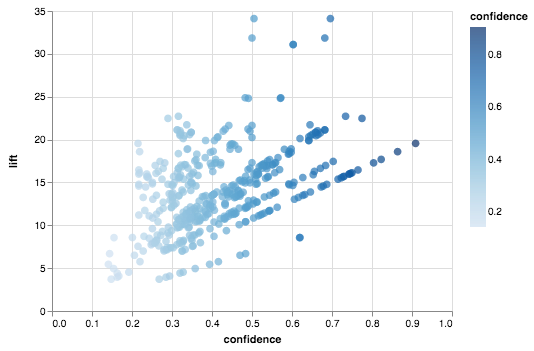

In [14]:
alt.Chart(apriori.rules_df).mark_circle(size=60).encode(
    x='confidence',
    y='lift',
    color='confidence',
    tooltip=['antecedent', 'consequent', 'confidence', 'lift']).interactive()